In [7]:
import sys, os

if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # specify the path of the folder containing "file_name" by changing the lecture index:
    path_to_file = '/content/gdrive/MyDrive/BT5153'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/BT5153
/content/gdrive/.shortcut-targets-by-id/1-EuPWwH26BHpNG41utRuC3Oo7qwXYRcD/BT5153


In [8]:
import shutil
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from tensorflow.keras.applications import MobileNetV2, ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
import pandas as pd
from tabulate import tabulate
from google.colab import drive
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

CNN

Label Map (class index → label):
0 → angry
1 → happy
2 → sad


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4888 - loss: 1.1944
Epoch 1: val_accuracy improved from -inf to 0.58059, saving model to /content/best_cnn_model.h5


388/388 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.4889 - loss: 1.1939 - val_accuracy: 0.5806 - val_loss: 0.8584
Epoch 2/10
387/388 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5993 - loss: 0.8388
Epoch 2: val_accuracy improved from 0.58059 to 0.58994, saving model to /content/best_cnn_model.h5


388/388 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.5993 - loss: 0.8388 - val_accuracy: 0.5899 - val_loss: 0.8514
Epoch 3/10
387/388 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6481 - loss: 0.7504
Epoch 3: val_accuracy did not improve from 0.58994
388/388 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.6481 - loss: 0.7504 - val_accuracy: 0.5828 - val_loss: 0.8755
Epoch 4/10
387/388 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7429 - loss: 0.5852
Epoch 4: val_accuracy did not improve from 0.58994
388/388 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.7428 - loss: 0.5853 - val_accuracy: 0.5806 - val_loss: 0.9652
Epoch 5/10
387/388 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8522 - loss: 0.3687
Epoch 5: val_accuracy did not improve from 0.58994
388/388 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.8521 - loss: 0.3688 - val_accuracy: 0.5609 - val_loss: 1.3806
Epoch 6/10
387/388 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9328 - loss: 0.1836
Epoch 6: val_accuracy d

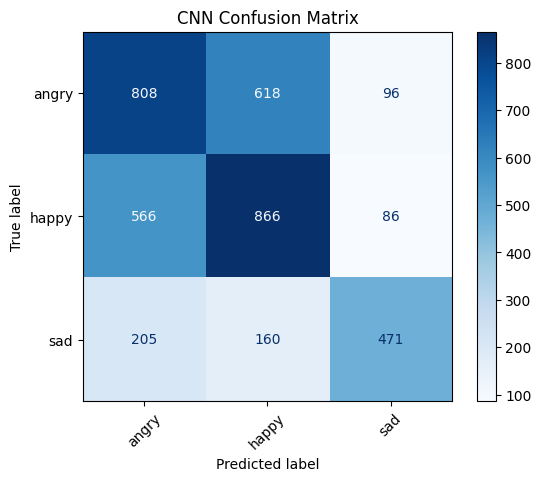

In [ ]:
train_dir = 'dog label/clean/train'
test_dir = 'dog label/clean/test'

target_ratio = (224, 224)

def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img = load_img(os.path.join(folder, filename), target_size=target_ratio)
            img_array = img_to_array(img)
            images.append(img_array)

            label = filename.split('_')[0]  # Extract label from filename
            labels.append(label)

    return np.array(images), np.array(labels)

train_images, train_labels = load_images_from_folder(train_dir)
test_images, test_labels = load_images_from_folder(test_dir)

# Normalize pixel values
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to categorical
label_map = {label: i for i, label in enumerate(np.unique(train_labels))}
print("Label Map (class index → label):")
for label, idx in label_map.items():
    print(f"{idx} → {label}")
train_labels = to_categorical([label_map[label] for label in train_labels])
test_labels = to_categorical([label_map[label] for label in test_labels])

cnn_checkpoint_path = '/content/best_cnn_model.h5'
cnn_checkpoint_cb = ModelCheckpoint(
    cnn_checkpoint_path,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(target_ratio[0], target_ratio[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(label_map), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 10

# Split train + val
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels,
    test_size=0.2, stratify=np.argmax(train_labels, axis=1), random_state=42
)


history = model.fit(X_train, y_train,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[cnn_checkpoint_cb]
                    )

y_true = np.argmax(test_labels, axis=1)
y_pred_probs = model.predict(test_images)
y_pred = np.argmax(model.predict(test_images), axis=1)
id_to_label = {v: k for k, v in label_map.items()}

print("\n Classification Report (including Recall, Precision, F1-score):\n")
print(classification_report(y_true, y_pred, target_names=[id_to_label[i] for i in range(len(label_map))]))

try:
    auc_macro = roc_auc_score(test_labels, y_pred_probs, multi_class='ovr', average='macro')
    auc_weighted = roc_auc_score(test_labels, y_pred_probs, multi_class='ovr', average='weighted')
    print(f"\n Macro-averaged ROC AUC: {auc_macro:.3f}")
    print(f" Weighted-averaged ROC AUC: {auc_weighted:.3f}")
except Exception as e:
    print(f"\n ROC AUC Error: {e}")

# Calculate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[id_to_label[i] for i in range(len(label_map))])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("CNN Confusion Matrix")
plt.show()


MobileNetV2

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint


In [10]:
# MobileNetV2
base_model = MobileNetV2(
    input_shape=(target_ratio[0], target_ratio[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze Conv layer

# Add classify layer
inputs = Input(shape=(target_ratio[0], target_ratio[1], 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(len(label_map), activation='softmax')(x)
mobilenet_model = Model(inputs, outputs)

mobilenet_model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])


Epoch 1/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5139 - loss: 1.0455
Epoch 1: val_accuracy improved from -inf to 0.67150, saving model to /content/best_mobilenet_model.h5


388/388 ━━━━━━━━━━━━━━━━━━━━ 40s 73ms/step - accuracy: 0.5140 - loss: 1.0451 - val_accuracy: 0.6715 - val_loss: 0.7264
Epoch 2/10
387/388 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6576 - loss: 0.7495
Epoch 2: val_accuracy improved from 0.67150 to 0.68601, saving model to /content/best_mobilenet_model.h5


388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.6577 - loss: 0.7495 - val_accuracy: 0.6860 - val_loss: 0.6894
Epoch 3/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6760 - loss: 0.7169
Epoch 3: val_accuracy improved from 0.68601 to 0.69600, saving model to /content/best_mobilenet_model.h5


388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.6760 - loss: 0.7169 - val_accuracy: 0.6960 - val_loss: 0.6796
Epoch 4/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6823 - loss: 0.6991
Epoch 4: val_accuracy did not improve from 0.69600
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.6823 - loss: 0.6991 - val_accuracy: 0.6947 - val_loss: 0.6675
Epoch 5/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6886 - loss: 0.6840
Epoch 5: val_accuracy did not improve from 0.69600
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6885 - loss: 0.6840 - val_accuracy: 0.6873 - val_loss: 0.6697
Epoch 6/10
386/388 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6956 - loss: 0.6685
Epoch 6: val_accuracy did not improve from 0.69600
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6956 - loss: 0.6687 - val_accuracy: 0.6763 - val_loss: 0.7307
Epoch 7/10
386/388 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6868 - loss: 0.6944
Epoch 7: val_accuracy i

388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.6868 - loss: 0.6944 - val_accuracy: 0.6973 - val_loss: 0.6721
Epoch 8/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6939 - loss: 0.6781
Epoch 8: val_accuracy did not improve from 0.69729
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.6939 - loss: 0.6782 - val_accuracy: 0.6957 - val_loss: 0.6740
Epoch 9/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6869 - loss: 0.6903
Epoch 9: val_accuracy did not improve from 0.69729
388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.6869 - loss: 0.6904 - val_accuracy: 0.6905 - val_loss: 0.6757
Epoch 10/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6946 - loss: 0.6696
Epoch 10: val_accuracy improved from 0.69729 to 0.69890, saving model to /content/best_mobilenet_model.h5


388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.6946 - loss: 0.6696 - val_accuracy: 0.6989 - val_loss: 0.6753
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.7655 - loss: 0.5726

 MobileNetV2 Test accuracy: 0.707
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step

 MobileNetV2 Classification Report (including Recall, Precision, F1-score):

              precision    recall  f1-score   support

       angry       0.69      0.63      0.66      1522
       happy       0.67      0.80      0.73      1518
         sad       0.85      0.68      0.75       836

    accuracy                           0.71      3876
   macro avg       0.74      0.70      0.71      3876
weighted avg       0.72      0.71      0.71      3876


 MobileNetV2 Macro AUC: 0.866
 MobileNetV2 Weighted AUC: 0.853


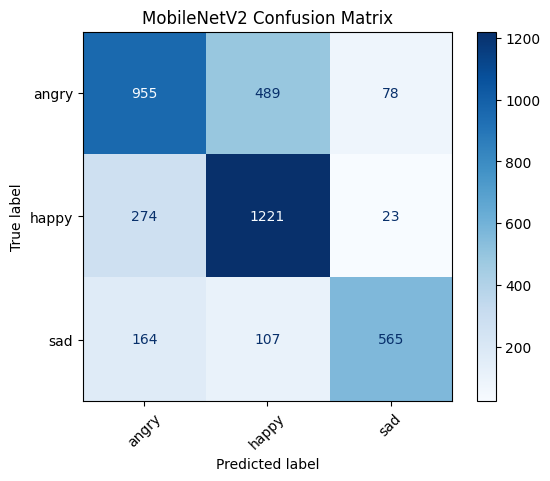

In [11]:
# Set checkpoint
checkpoint_path = '/content/best_mobilenet_model.h5'
checkpoint_cb = ModelCheckpoint(checkpoint_path, save_best_only=True,
                                monitor='val_accuracy', mode='max', verbose=1)

# Train MobileNetV2
mobilenet_history = mobilenet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=[checkpoint_cb]
)

# Eval
test_loss, test_acc = mobilenet_model.evaluate(test_images, test_labels)
print(f'\n MobileNetV2 Test accuracy: {test_acc:.3f}')

# Show metrics
y_pred_probs_mb = mobilenet_model.predict(test_images)
y_pred_mb = np.argmax(y_pred_probs_mb, axis=1)

print("\n MobileNetV2 Classification Report (including Recall, Precision, F1-score):\n")
print(classification_report(y_true, y_pred_mb, target_names=[id_to_label[i] for i in range(len(label_map))]))

try:
    auc_macro_mb = roc_auc_score(test_labels, y_pred_probs_mb, multi_class='ovr', average='macro')
    auc_weighted_mb = roc_auc_score(test_labels, y_pred_probs_mb, multi_class='ovr', average='weighted')
    print(f"\n MobileNetV2 Macro AUC: {auc_macro_mb:.3f}")
    print(f" MobileNetV2 Weighted AUC: {auc_weighted_mb:.3f}")
except Exception as e:
    print(f"\n ROC AUC Error (MobileNetV2): {e}")

# Calculate Confusion Matrix
cm = confusion_matrix(y_true, y_pred_mb)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[id_to_label[i] for i in range(len(label_map))])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("MobileNetV2 Confusion Matrix")
plt.show()
